# Test Attack

In [1]:
import os

In [34]:
g_path = "/remote-home/songtianwei/research/unlearn_multimodal/output/text_guide_target_gen_nus-wide_ViT-B-16/checkpoint_epoch_195.pth"

In [3]:
import argparse
import torch
import clip
import os
from torchvision.datasets import  MNIST, CIFAR10, CIFAR100, ImageNet
import numpy as np
from tqdm import tqdm
import ruamel.yaml as yaml
import clip
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from models.model_gan_generator import NetG
import utils

import torch.nn.functional as F

In [5]:
device = "cuda:1"

In [35]:
generator = NetG()
checkpoint = torch.load(g_path, map_location=device)
generator.load_state_dict(checkpoint['model'])
generator = generator.to(device)

In [36]:
def _convert_image_to_rgb(image):
    return image.convert("RGB")

In [37]:

# [224,224]
clip_transform = transforms.Compose([
    Resize((224,224),interpolation=BICUBIC),
    CenterCrop(224),
    _convert_image_to_rgb,
    ToTensor(),
])
clip_normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

prompt_templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]


def zeroshot_classifier(clip_model, device, classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).to(device) #tokenize
            class_embeddings = clip_model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights


@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


In [38]:
dataset = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False, transform=clip_transform)

Files already downloaded and verified


In [39]:
data1 = dataset[1]

In [40]:
data1

(tensor([[[0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.3451, 0.3412, 0.3373,  ..., 0.7294, 0.7333, 0.7333],
          [0.3451, 0.3412, 0.3373,  ..., 0.7294, 0.7333, 0.7333],
          [0.3451, 0.3412, 0.3373,  ..., 0.7294, 0.7333, 0.7333]],
 
         [[0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.4078, 0.4039, 0.4039,  ..., 0.7843, 0.7843, 0.7882],
          [0.4078, 0.4039, 0.4039,  ..., 0.7843, 0.7843, 0.7882],
          [0.4078, 0.4039, 0.4078,  ..., 0.7843, 0.7843, 0.7882]],
 
         [[0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ...,

In [12]:
model, preprocess = clip.load("ViT-B/16")

In [13]:
model = model.float()
model = model.to(device)

In [14]:
class_names = dataset.classes
    
zeroshot_weights = zeroshot_classifier(model, device, class_names, prompt_templates)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


In [15]:
image, target = data1

In [16]:
image = image.to(device)

In [17]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [18]:
target

8

In [19]:
image_norm = clip_normalize(image)
image_norm = image_norm.unsqueeze(0)
image_feature = model.encode_image(image_norm)

In [20]:
image_feature.shape

torch.Size([1, 512])

In [21]:
image_feature /= image_feature.norm(dim=-1, keepdim=True)
logits = 100. * image_feature @ zeroshot_weights

In [22]:
pred = logits.topk(1, 1, True, True)[1].t()

In [23]:
print(pred, target)

tensor([[8]], device='cuda:1') 8


In [24]:
image.shape

torch.Size([3, 224, 224])

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_tensor_as_rgb(tensor):
    if tensor.shape[0] != 3:
        raise ValueError("The first dimension of the tensor must be 3 to represent RGB channels.")
    print(tensor.shape)
    
    # Transpose the tensor to have shape [h, w, c]
    rgb_image = tensor.permute(1, 2, 0).detach().cpu().numpy()

    # Clip values to be in the range [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)

    # Display the RGB image
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

torch.Size([3, 224, 224])


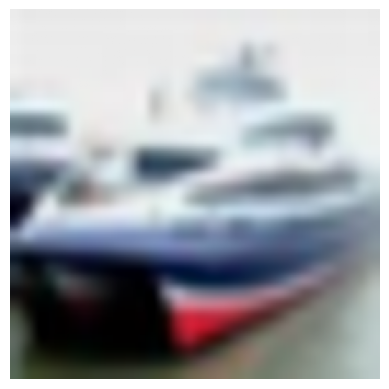

In [26]:
visualize_tensor_as_rgb(image)

In [27]:
class_name = dataset.classes[target]

In [50]:
class_name

'ship'

In [66]:
# use the first prompt template
# rand_index = np.random.randint(0, len(prompt_templates))
# text_of_target_class = prompt_templates[rand_index].format(class_name)
the_prompt = "A photo of " + str(dataset.classes[1])
print("the prompt" , the_prompt)
text_tokens = clip.tokenize(the_prompt).to(device)

noise = torch.randn(1, 100).to(device)
text_embedding = model.encode_text(text_tokens)
sec_emb = text_embedding.to(device)
gen_image, _ = generator(noise, sec_emb)
delta_im = gen_image

norm_type = "l2"
epsilon = 8
if norm_type == "l2":
    temp = torch.norm(delta_im.view(delta_im.shape[0], -1), dim=1).view(-1, 1, 1, 1)
    delta_im = delta_im * epsilon / temp
elif norm_type == "linf":
    delta_im = torch.clamp(delta_im, -epsilon / 255., epsilon / 255)  # torch.Size([16, 3, 256, 256])

delta_im = delta_im.to(image.device)
delta_im = F.interpolate(delta_im, (image.shape[-2], image.shape[-1]))

# add delta(noise) to image
images_adv = torch.clamp(image + delta_im, min=0, max=1)
images_adv_norm = clip_normalize(images_adv)

image_features_adv = model.encode_image(images_adv_norm)
    
image_features_adv /= image_features_adv.norm(dim=-1, keepdim=True)
logits_adv = 100. * image_features_adv @ zeroshot_weights

the prompt A photo of automobile


torch.Size([3, 224, 224])


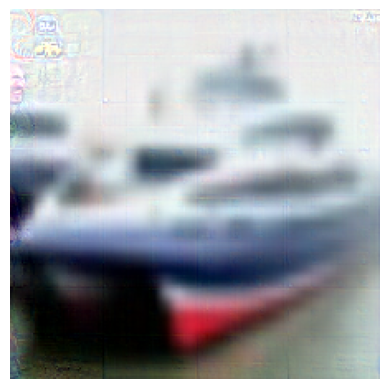

In [67]:
visualize_tensor_as_rgb(images_adv[0])

In [68]:
pred_adv = logits_adv.topk(1, 1, True, True)[1].t()

In [69]:
pred_adv

tensor([[9]], device='cuda:1')

In [70]:
dataset.classes[pred_adv]

'truck'

# About the dataset

In [1]:
from utils.load_data import load_class_dataset, load_pair_dataset

In [2]:
dataset = load_pair_dataset("nus-wide",64)

In [3]:
train_dataset = dataset['train']

In [4]:
dataset

{'train': <utils.load_data.CustomDataSet at 0x7f4c871392e0>,
 'test': <utils.load_data.CustomDataSet at 0x7f4c87139340>}

In [5]:
test_dataset = dataset['test']

In [6]:
train_dataset[0][1]

array([[49406,  1449,  1215,  2242,  1794,  3095,  6829,  3773,  6298,
         1012,  8231, 49407,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])

In [7]:
print(len(test_dataset))

2000


In [8]:
text = "dog"

In [9]:
import clip

In [10]:
sec_text_token = clip.tokenize(text)

In [11]:
sec_text_token

tensor([[49406,  1929, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [12]:
sec_text_token.shape

torch.Size([1, 77])

In [13]:
the_word_token_num = sec_text_token[0][1]

In [14]:
the_word_token_num

tensor(1929, dtype=torch.int32)

In [15]:
print(len(train_dataset))

8000


In [16]:
test_dataset = dataset

In [17]:
for img,token,labels,idx in train_dataset:
    if the_word_token_num in token[0]:
        print("!")
        print(the_word_token_num)
        break
    print(token[0])
print("?")

[49406  1449  1215  2242  1794  3095  6829  3773  6298  1012  8231 49407
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[49406   794  5352  6867 49407     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[49406  5250  8700 49407     0     0     0     0     0     0

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
wiki_dataset = load_pair_dataset("wiki", 64)

In [19]:
wiki_train_dataset = wiki_dataset['train']

In [20]:
wiki_test_dataset = wiki_dataset['test']

In [21]:
print(len(wiki_train_dataset), len(wiki_test_dataset))

2157 462


In [22]:
from utils.load_data import load_class_dataset    

In [23]:
from utils.clip_util import clip_transform, clip_normalize

In [25]:
imagenet_dataset = load_class_dataset("ImageNet",None)

In [26]:
imagenet_train_dataset, imagenet_val_dataset = imagenet_dataset

In [27]:
dog_label_nums = []

In [28]:
for idx,class_name in enumerate(imagenet_train_dataset.classes):
    add_num = False
    if class_name[0] == 'hotdog':
        continue
    for each_name in class_name:
        if "dog" in each_name:
            add_num = True
            break
    if add_num:
        dog_label_nums.append(idx)
        print(class_name)

('Maltese dog', 'Maltese terrier', 'Maltese')
('Tibetan terrier', 'chrysanthemum dog')
('Old English sheepdog', 'bobtail')
('Shetland sheepdog', 'Shetland sheep dog', 'Shetland')
('German shepherd', 'German shepherd dog', 'German police dog', 'alsatian')
('Greater Swiss Mountain dog',)
('Bernese mountain dog',)
('French bulldog',)
('Eskimo dog', 'husky')
('dalmatian', 'coach dog', 'carriage dog')
('affenpinscher', 'monkey pinscher', 'monkey dog')
('pug', 'pug-dog')
('Newfoundland', 'Newfoundland dog')
('African hunting dog', 'hyena dog', 'Cape hunting dog', 'Lycaon pictus')
('dogsled', 'dog sled', 'dog sleigh')


In [29]:
dog_label_nums

[153, 200, 229, 230, 235, 238, 239, 245, 248, 251, 252, 254, 256, 275, 537]

In [30]:
the_dict = imagenet_train_dataset.class_to_idx

In [31]:
the_dict['hotdog']

934

In [32]:
for data in imagenet_train_dataset:
    print(data)
    break

(<PIL.Image.Image image mode=RGB size=250x250 at 0x7F4C3488B190>, 0)


In [33]:
from torchvision.utils import save_image

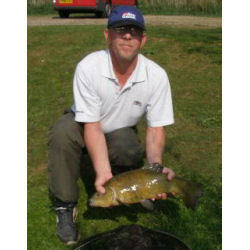

In [34]:
data[0]

In [35]:
import os

In [36]:
os.getcwd()

'/remote-home/songtianwei/research/unlearn_multimodal'

In [37]:
target_save_path = os.path.join(os.getcwd(),"data")

In [38]:
folder_name = "my-image-net_" + "dog"

In [39]:
output_dir = os.path.join(target_save_path, folder_name)

In [40]:
output_dir

'/remote-home/songtianwei/research/unlearn_multimodal/data/my-image-net_dog'

In [41]:
from pathlib import Path

In [42]:
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [43]:
from tqdm import tqdm

In [44]:
json_data = {}

In [45]:
for idx,(img,label) in tqdm(enumerate(imagenet_train_dataset)):
    if label in dog_label_nums:
        img_name = str(idx) + ".jpg"
        print(os.path.join(output_dir, img_name))
        img.save(os.path.join(output_dir, img_name))
        break
    break

0it [00:00, ?it/s]


In [46]:
# 定义要筛选的类别索引列表  
selected_classes = [51, 67, 84]  # 替换为你要筛选的类别索引  

In [48]:
from torch_geometric.data import InMemoryDataset

In [51]:
imagenet_train_dataset

Dataset ImageNet
    Number of datapoints: 1281167
    Root location: /remote-home/songtianwei/research/unlearn_multimodal/data/imagenet
    Split: train

In [60]:
folder_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/dog_dataset/"

In [68]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


dataset = ImageFolder(root=folder_path)

In [69]:
len(dataset)

12500

# 3.Test InfoNCE

In [76]:
from utils.nce import InfoNCE

In [97]:
loss_fn = InfoNCE(reduction='mean',negative_mode='unpaired')

In [98]:
import torch

In [109]:
# Tip the batch of query and positive_keys must be the same
query = torch.zeros((16,512))
positive_key = torch.ones((16,512))
negative_keys = torch.ones((10,512))

In [110]:
loss1 = loss_fn(query, positive_key, negative_keys)

In [111]:
loss2 = loss_fn(query, positive_key)

In [112]:
loss1

tensor(2.3979)

In [103]:
loss2

tensor(2.7726)